# Coding Temple Capstone I: Caravan Insurance

## Harry Hill - May 2023

### Step 1: Data Collection

Dataset: Caravan Insurance Challenge, updated 2017 https://www.kaggle.com/datasets/uciml/caravan-insurance-challenge
P. van der Putten and M. van Someren (eds) . CoIL Challenge 2000: The Insurance Company Case. Published by Sentient Machine Research, Amsterdam. Also a Leiden Institute of Advanced Computer Science Technical Report 2000-09. June 22, 2000.

Context: Caravan Insurance protects a mobile-home in the event it is damaged or stolen. Information was collected on a large group of people, a 6% sample of which chose to buy caravan insurance.

Format: 1 csv file, tabular

Defining Question: Which customers were more likely to be interested in buying Caravan Insurance and why? 

Hypothesis: If the archetypal retired couple traveling on their savings holds true, then the the average caravan insurance holder will have at least one car, be older and more financially stable, and consist of a family of at least two people who tend to have other insurance policies.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

def read_csv(filename):
    """
    Return a .csv file as a list.
    """
    with open(filename, 'r') as f:
        data = list(csv.reader(f))
    return data

file_path = "../files/caravan.csv"

data_list = read_csv(file_path)

# convert to dataframe
df = pd.DataFrame(data_list)
pd.set_option('display.max_column',None)
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
0,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,MINK123M,MINKGEM,MKOOPKLA,PWAPART,PWABEDR,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
1,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,0,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,train,23,1,2,1,5,0,5,0,5,0,6,3,3,5,2,0,5,4,2,0,0,4,2,2,2,2,2,4,2,9,0,5,3,3,9,0,5,2,3,0,0,3,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,train,39,2,3,2,9,2,2,0,5,7,2,0,0,3,6,0,4,5,0,0,0,4,1,5,0,1,4,5,0,6,3,8,0,1,9,0,4,3,3,0,0,3,5,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,train,33,1,2,3,8,0,7,0,2,7,2,0,0,5,4,0,3,6,2,0,0,2,5,2,2,1,2,5,2,0,9,4,4,2,6,3,2,5,3,0,0,3,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,train,33,1,2,4,8,0,1,3,6,6,0,3,3,3,3,0,1,8,1,1,0,1,8,1,1,1,0,8,1,9,0,5,2,3,7,2,7,2,1,0,0,2,3,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Step 2: Data Cleaning

Data Setup:
* each observation is an aggregated postal code 'customer'; some categorical variables seem to be the average or mode of the customers in the area
* this dataset was originally created as part of a Kaggle competition in two parts, train and test (ORIGIN variable), so that machine learning could be used to predict the target CARAVAN variable in the test dataset. The competition is over and the two parts have been combined for a bigger dataset
* header codes
    * 'M-' ; demographic statistics
    * 'P-' ; product ownership / contribution ; 0-6 with 0 being not having the policy, 1 being low contribution(deductible)/high premium, 6 being high contribution(deductible)/low premium
    * 'A-' ; insurance statistics / number of policies ; how many of this policy the 'customer' has (usually 0,1, or 2)
        
Initial Issues:
1. Most columns have an uppercase code instead of a legible header
    - convert to concise and descriptive headers
2. Several columns' values are numeric keys for short phrases
    1. analyze data while referring to keys
    2. convert key values to descriptive value (could make it harder to do some analyses on them)
        - create dictionaries for keys
        - create function that converts each value in a column
3. There is no index column for actual postal code, only the index created when the data was converted to a dataframe
4. The demograpghic columns could be further organized into demographic aspects (Religion, relationship status, household size, education level, employment type, social class, home ownership, number of cars, health insurance, income level)
    - will have to analyze in chunks or aggregate into single columns
    - 'M-' header code (M)
    - '-DAC-' demographic aspect code (GOD, REL, F, OPL, BER, SK, H, AUT, Z, INK)  
5. Hidden aggregation of 'customer' observation leads to questions for data interpretation; average customer in postal code? one customer selected from each postal code?
6. Demographic variables have categorical numerical keys pointing to a range which makes for difficult analyses (i.e. customer age bin #1 is 20-30 years). Includes L1, L3, and L4 variables
    1. Replace  with the median value of each bin -> customer age #1 is 25 years old
    2. Generate a random number within the specified range for each observation

1. Postal Code Demographic Statistics    
    MOSTYPE: Customer Subtype; see L0
        L0: Customer subtype
            1: High Income, expensive child
            2: Very Important Provincials
            3: High status seniors
            4: Affluent senior apartments
            5: Mixed seniors
            6: Career and childcare
            7: DINK's (double income no kids)
            8: Middle class families
            9: Modern, complete families
            10: Stable family
            11: Family starters
            12: Affluent young families
            13: Young all american family
            14: Junior cosmopolitan
            15: Senior cosmopolitans
            16: Students in apartments
            17: Fresh masters in the city
            18: Single youth
            19: Suburban youth
            20: Etnically diverse
            21: Young urban have-nots
            22: Mixed apartment dwellers
            23: Young and rising
            24: Young, low educated
            25: Young seniors in the city
            26: Own home elderly
            27: Seniors in apartments
            28: Residential elderly
            29: Porchless seniors: no front yard
            30: Religious elderly singles
            31: Low income catholics
            32: Mixed seniors
            33: Lower class large families
            34: Large family, employed child
            35: Village families
            36: Couples with teens 'Married with children'
            37: Mixed small town dwellers
            38: Traditional families
            39: Large religous families
            40: Large family farms
            41: Mixed rurals
    MAANTHUI: Number of houses 1 - 10
    MGEMOMV: Avg size household 1 - 6
    MGEMLEEF: Avg age; see L1
        L1: average age keys:
            1: 20-30 years
            2: 30-40 years
            3: 40-50 years
            4: 50-60 years
            5: 60-70 years
            6: 70-80 years
    MOSHOOFD: Customer main type; see L2
        L2: customer main type keys:
            1: Successful hedonists
            2: Driven Growers
            3: Average Family
            4: Career Loners
            5: Living well
            6: Cruising Seniors
            7: Retired and Religeous
            8: Family with grown ups
            9: Conservative families
            10: Farmers
    Postal Code Group Percentages
        L3: percentage keys:
            0: 0%
            1: 1 - 10%
            2: 11 - 23%
            3: 24 - 36%
            4: 37 - 49%
            5: 50 - 62%
            6: 63 - 75%
            7: 76 - 88%
            8: 89 - 99%
            9: 100%
        MGODRK: Roman catholic
        MGODPR: Protestant …
        MGODOV: Other religion
        MGODGE: No religion
        MRELGE: Married
        MRELSA: Living together
        MRELOV: Other relation
        MFALLEEN: Singles
        MFGEKIND: Household without children
        MFWEKIND: Household with children
        MOPLHOOG: High level education
        MOPLMIDD: Medium level education
        MOPLLAAG: Lower level education
        MBERHOOG: High status
        MBERZELF: Entrepreneur
        MBERBOER: Farmer
        MBERMIDD: Middle management
        MBERARBG: Skilled labourers
        MBERARBO: Unskilled labourers
        MSKA: Social class A
        MSKB1: Social class B1
        MSKB2: Social class B2
        MSKC: Social class C
        MSKD: Social class D
        MHHUUR: Rented house
        MHKOOP: Home owners
        MAUT1: 1 car
        MAUT2: 2 cars
        MAUT0: No car
        MZFONDS: National Health Service
        MZPART: Private health insurance
        MINKM30: Income < 30.000
        MINK3045: Income 30-45.000
        MINK4575: Income 45-75.000
        MINK7512: Income 75-122.000
        MINK123M: Income >123.000
        MINKGEM: Average income
        MKOOPKLA: Purchasing power class
    
2. Postal Code Product Ownership Statistics
    L4: total number keys:
        0: 0
        1: 1 - 49
        2: 50 - 99
        3: 100 - 199
        4: 200 - 499
        5: 500 - 999
        6: 1000 - 4999
        7: 5000 - 9999
        8: 10,000 - 19,999
        9: >= 20,000
    * PWAPART: Contribution private third party insurance
    * PWABEDR: Contribution third party insurance (firms) …
    * PWALAND: Contribution third party insurane (agriculture)
    * PPERSAUT: Contribution car policies
    * PBESAUT: Contribution delivery van policies
    * PMOTSCO: Contribution motorcycle/scooter policies
    * PVRAAUT: Contribution lorry policies
    * PAANHANG: Contribution trailer policies
    * PTRACTOR: Contribution tractor policies
    * PWERKT: Contribution agricultural machines policies
    * PBROM: Contribution moped policies
    * PLEVEN: Contribution life insurances
    * PPERSONG: Contribution private accident insurance policies
    * PGEZONG: Contribution family accidents insurance policies
    * PWAOREG: Contribution disability insurance policies
    * PBRAND: Contribution fire policies
    * PZEILPL: Contribution surfboard policies
    * PPLEZIER: Contribution boat policies
    * PFIETS: Contribution bicycle policies
    * PINBOED: Contribution property insurance policies
    * PBYSTAND: Contribution social security insurance policies
3. Postal Code Insurance Statistics (Number of Policies)
    * AWAPART: Number of private third party insurance 1 - 12
    * AWABEDR: Number of third party insurance (firms) …
    * AWALAND: Number of third party insurance (agriculture)
    * APERSAUT: Number of car policies
    * ABESAUT: Number of delivery van policies
    * AMOTSCO: Number of motorcycle/scooter policies
    * AVRAAUT: Number of lorry policies
    * AAANHANG: Number of trailer policies
    * ATRACTOR: Number of tractor policies
    * AWERKT: Number of agricultural machines policies
    * ABROM: Number of moped policies
    * ALEVEN: Number of life insurances
    * APERSONG: Number of private accident insurance policies
    * AGEZONG: Number of family accidents insurance policies
    * AWAOREG: Number of disability insurance policies
    * ABRAND: Number of fire policies
    * AZEILPL: Number of surfboard policies
    * APLEZIER: Number of boat policies
    * AFIETS: Number of bicycle policies
    * AINBOED: Number of property insurance policies
    * ABYSTAND: Number of social security insurance policies

In [34]:
# make the first row the column headers (ONLY DO ONCE)
# df.columns = df.iloc[0]

# remove first row from DataFrame (ONLY DO ONCE)
# df = df[1:]

# view updated DataFrame
df.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,MINK123M,MINKGEM,MKOOPKLA,PWAPART,PWABEDR,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
1,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,0,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [36]:
# Rename demographic (M-) column names using dictionary of old:new names
df.rename(
    columns={
        # dataset origin
        "ORIGIN": "origin",
        # customer fields
        "MOSTYPE": "subtype_L0",
        "MAANTHUI": "num_houses",
        "MGEMOMV": "avg_household_size",
        "MGEMLEEF": "avg_age_L1",
        "MOSHOOFD": "main_type_L2",
        # religions (-GOD-)
        "MGODRK": "roman_catholic",
        "MGODPR": "protestant",
        "MGODOV": "other_religion",
        "MGODGE": "no_religion",
        # relationship status (-REL-)
        "MRELGE": "married",
        "MRELSA": "live_together",
        "MRELOV": "other_relation",
        # household size (-F-)
        "MFALLEEN": "singles",
        "MFGEKIND": "hh_wo_children",
        "MFWEKIND": "hh_with_children",
        # education level (-OPL-)
        "MOPLHOOG": "high_edu",
        "MOPLMIDD": "mid_edu",
        "MOPLLAAG": "low_edu",
        # employment type (-BER-)
        "MBERHOOG": "high_status",
        "MBERZELF": "entrepreneur",
        "MBERBOER": "farmer",
        "MBERMIDD": "middle_management",
        "MBERARBG": "skilled_labor",
        "MBERARBO": "unskilled_labor",
        # social class (-SK-)
        "MSKA": "social_A",
        "MSKB1": "social_B1",
        "MSKB2": "social_B2",
        "MSKC": "social_C",
        "MSKD": "social_D",
        # home ownership (-H-)
        "MHHUUR": "renting",
        "MHKOOP": "owners",
        # car ownership (-AUT-)
        "MAUT1": "one_car",
        "MAUT2": "two_cars",
        "MAUT0": "no_cars",
        # health insurance (-Z-)
        "MZFONDS": "nhs_ins",
        "MZPART": "private_ins",
        # income level (-INK-)
        "MINKM30": "lt_30k",
        "MINK3045": "30k-45k",
        "MINK4575": "45k-75k",
        "MINK7512": "75k-122k",
        "MINK123M": "gt-123k",
        "MINKGEM": "avg_income",
        # purchasing power class
        "MKOOPKLA": "purchasing_power"
    },
    inplace=True
)

# Rename policy contribution level (P-) column names using dictionary of old:new names
df.rename(
    columns={
        "PWAPART": "private_third_party",
        "PWABEDR": "firm_third_party",
        "PWALAND": "agriculture_third_party",
        "PPERSAUT": "personal_car",
        "PBESAUT": "delivery_van",
        "PMOTSCO": "motorcycle",
        "PVRAAUT": "truck",
        "PTRACTOR": "tractor",
        "PAANHANG": "trailer",
        "PWERKT": "agricultural_machine",
        "PBROM": "moped",
        "PLEVEN": "life",
        "PPERSONG": "private_accident",
        "PGEZONG": "family_accident",
        "PWAOREG": "disability",
        "PBRAND": "fire",
        "PZEILPL": "surfboard",
        "PPLEZIER": "boat",
        "PFIETS": "bicycle",
        "PINBOED": "property",
        "PBYSTAND": "social_security"        
    },
    inplace=True
)

# Rename number of policies (A-) column names using dictionary of old:new names
df.rename(
    columns={
        "AWAPART": "num_private_third_party",
        "AWABEDR": "num_firm_third_party",
        "AWALAND": "num_agriculture_third_party",
        "APERSAUT": "num_personal_car",
        "ABESAUT": "num_delivery_van",
        "AMOTSCO": "num_motorcycle",
        "AVRAAUT": "num_truck",
        "AAANHANG": "num_trailer",
        "ATRACTOR": "num_tractor",
        "AWERKT": "num_agricultural_machine",
        "ABROM": "num_moped",
        "ALEVEN": "num_life",
        "APERSONG": "num_private_accident",
        "AGEZONG": "num_family_accident",
        "AWAOREG": "num_disability",
        "ABRAND": "num_fire",
        "AZEILPL": "num_surfboard",
        "APLEZIER": "num_boat",
        "AFIETS": "num_bicycle",
        "AINBOED": "num_property",
        "ABYSTAND": "num_social_security"        
    },
    inplace=True
)
    
# Rename target variable (CARAVAN) column name
df.rename(columns={"CARAVAN": "caravan"}, inplace=True)

# view updated 
df.head(20)

,origin,subtype_L0,num_houses,avg_household_size,avg_age_L1,main_type_L2,roman_catholic,protestant,other_religion,no_religion,married,live_together,other_relation,singles,hh_wo_children,hh_with_children,high_edu,mid_edu,low_edu,high_status,entrepreneur,farmer,middle_management,skilled_labor,unskilled_labor,social_A,social_B1,social_B2,social_C,social_D,renting,owners,one_car,two_cars,no_cars,nhs_ins,private_ins,lt_30k,30k-45k,45k-75k,75k-122k,gt-123k,avg_income,purchasing_power,private_third_party,firm_third_party,agriculture_third_party,personal_car,delivery_van,motorcycle,truck,trailer,tractor,agricultural_machine,moped,life,private_accident,family_accident,disability,fire,surfboard,boat,bicycle,property,social_security,num_private_third_party,num_firm_third_party,num_agriculture_third_party,num_personal_car,num_delivery_van,num_motorcycle,num_truck,num_trailer,num_tractor,num_agricultural_machine,num_moped,num_life,num_private_accident,num_family_accident,num_disability,num_fire,num_surfboard,num_boat,num_bicycle,num_property,num_social_security,caravan
1,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,0,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,train,23,1,2,1,5,0,5,0,5,0,6,3,3,5,2,0,5,4,2,0,0,4,2,2,2,2,2,4,2,9,0,5,3,3,9,0,5,2,3,0,0,3,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,train,39,2,3,2,9,2,2,0,5,7,2,0,0,3,6,0,4,5,0,0,0,4,1,5,0,1,4,5,0,6,3,8,0,1,9,0,4,3,3,0,0,3,5,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,train,33,1,2,3,8,0,7,0,2,7,2,0,0,5,4,0,3,6,2,0,0,2,5,2,2,1,2,5,2,0,9,4,4,2,6,3,2,5,3,0,0,3,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,train,33,1,2,4,8,0,1,3,6,6,0,3,3,3,3,0,1,8,1,1,0,1,8,1,1,1,0,8,1,9,0,5,2,3,7,2,7,2,1,0,0,2,3,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,train,11,2,3,3,3,3,5,0,2,7,0,2,2,2,6,0,4,5,2,0,0,3,3,3,1,2,1,4,2,0,9,6,1,2,6,3,2,3,3,1,0,4,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Data Collection Summary: 

1. Moved header codes from first row to column labels
2. Converted header codes to descriptive titles

### Step 3: Data Analysis

Exploratory Data Analysis:
    - info() -> data types? null values?
    - describe() -> descriptive statistics
    - groupby() -> categorical columns with keys
    - matplotlib -> data visualization for key columns
    - refine hypothesis?
   
Diagnostic Data Analysis:
    - graphing distributions of variables with Caravan vs No Caravan in Tableau
    - identify demographics with most caravan policies

In [38]:
# check data types of columns and non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 1 to 9822
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   origin                       9822 non-null   object
 1   subtype_L0                   9822 non-null   object
 2   num_houses                   9822 non-null   object
 3   avg_household_size           9822 non-null   object
 4   avg_age_L1                   9822 non-null   object
 5   main_type_L2                 9822 non-null   object
 6   roman_catholic               9822 non-null   object
 7   protestant                   9822 non-null   object
 8   other_religion               9822 non-null   object
 9   no_religion                  9822 non-null   object
 10  married                      9822 non-null   object
 11  live_together                9822 non-null   object
 12  other_relation               9822 non-null   object
 13  singles                      9822

In [43]:
# ignore 'origin' column strings when describing
# interpret column object values as integers
print(df.iloc[:,1:].astype(int).describe())

# 9822 observations
# average number of houses 1.1
# average household size 2.7, median 3
# average age 3 (20-30 years), median 3

# IDEA: create subset of only buyers and do same; compare (element-wise subtraction?)

0       subtype_L0   num_houses  avg_household_size   avg_age_L1  \
count  9822.000000  9822.000000         9822.000000  9822.000000   
mean     24.253207     1.108735            2.677561     2.996437   
std      12.918058     0.412101            0.780701     0.804660   
min       1.000000     1.000000            1.000000     1.000000   
25%      10.000000     1.000000            2.000000     2.000000   
50%      30.000000     1.000000            3.000000     3.000000   
75%      35.000000     1.000000            3.000000     3.000000   
max      41.000000    10.000000            6.000000     6.000000   

0      main_type_L2  roman_catholic   protestant  other_religion  no_religion  \
count   9822.000000     9822.000000  9822.000000     9822.000000  9822.000000   
mean       5.779067        0.700672     4.637650        1.050092     3.262981   
std        2.874148        1.015107     1.721212        1.011156     1.606287   
min        1.000000        0.000000     0.000000        0.00000

In [68]:
# export cleaned dataframe to csv file for RStudio and Tableau analysis
df.to_csv('../files/caravan_cleaned.csv')

/var/folders/l6/k0bks1dx4wd409pkxgr263rm0000gn/T/ipykernel_27541/2531718876.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1 = df.drop('origin', 1)


array([[<AxesSubplot:title={'center':'subtype_L0'}>,
        <AxesSubplot:title={'center':'num_houses'}>,
        <AxesSubplot:title={'center':'avg_household_size'}>,
        <AxesSubplot:title={'center':'avg_age_L1'}>,
        <AxesSubplot:title={'center':'main_type_L2'}>,
        <AxesSubplot:title={'center':'roman_catholic'}>,
        <AxesSubplot:title={'center':'protestant'}>,
        <AxesSubplot:title={'center':'other_religion'}>,
        <AxesSubplot:title={'center':'no_religion'}>],
       [<AxesSubplot:title={'center':'married'}>,
        <AxesSubplot:title={'center':'live_together'}>,
        <AxesSubplot:title={'center':'other_relation'}>,
        <AxesSubplot:title={'center':'singles'}>,
        <AxesSubplot:title={'center':'hh_wo_children'}>,
        <AxesSubplot:title={'center':'hh_with_children'}>,
        <AxesSubplot:title={'center':'high_edu'}>,
        <AxesSubplot:title={'center':'mid_edu'}>,
        <AxesSubplot:title={'center':'low_edu'}>],
       [<AxesSubplot:t

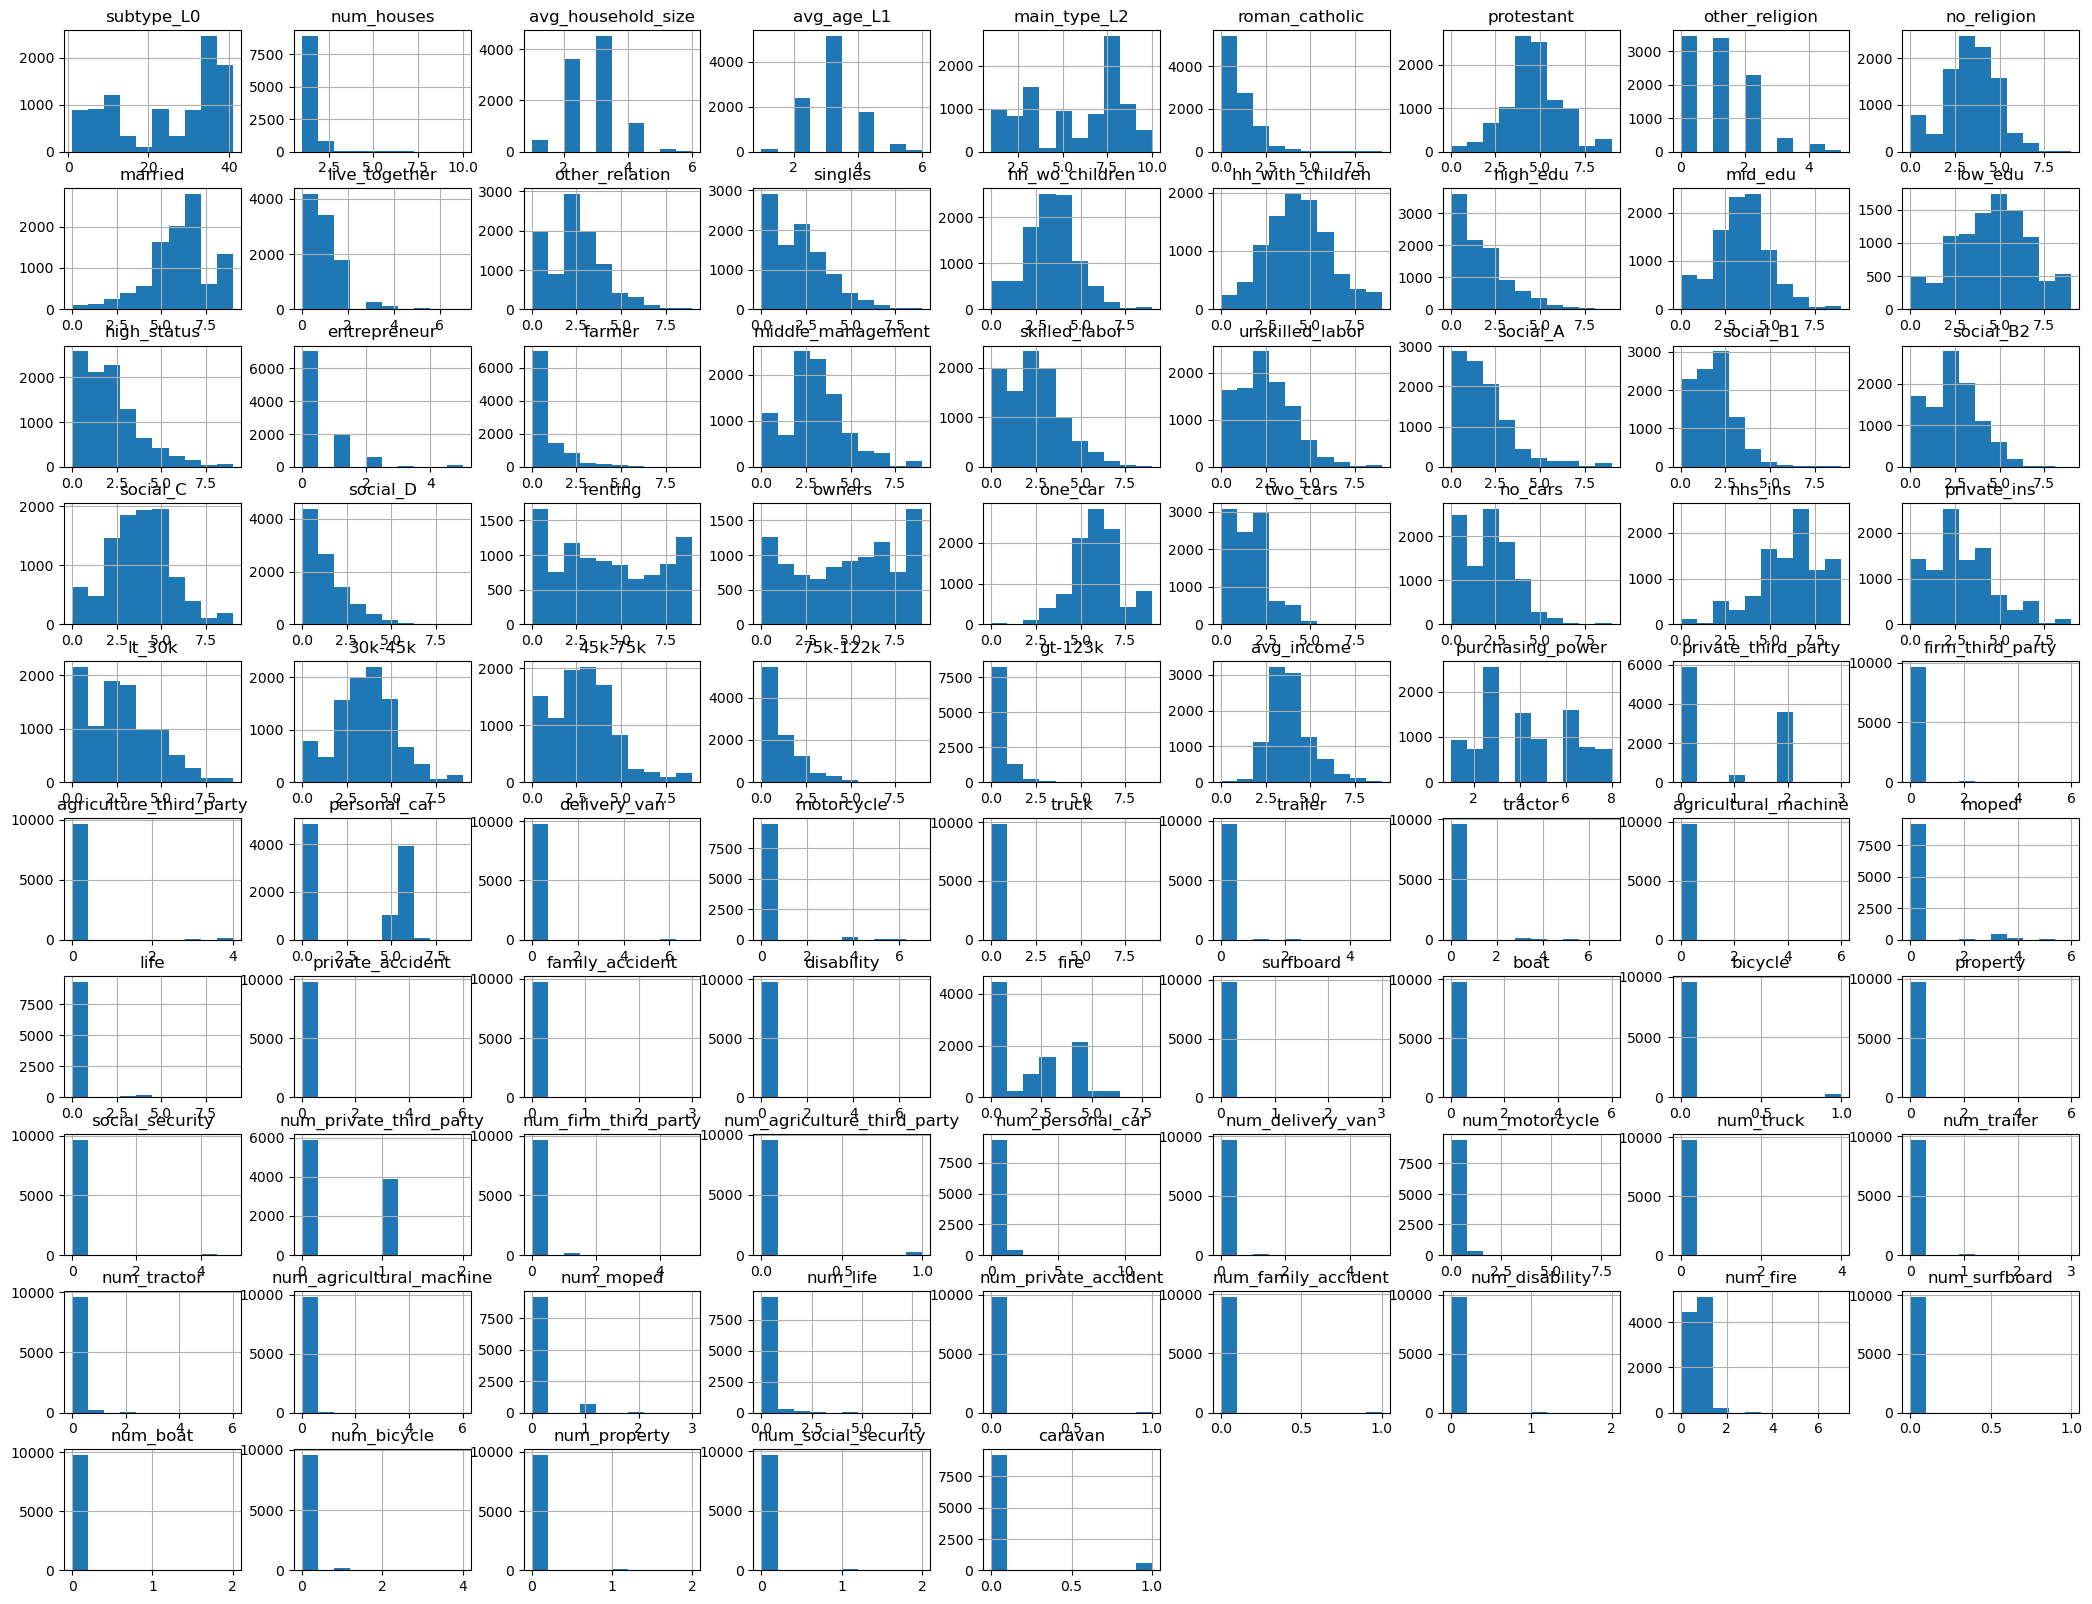

In [85]:
df1 = df.drop('origin', 1)

df1.astype(int).hist(figsize=(26,20))

In [16]:
# possible work for further work with cleaned csv (linear regressions?)

# data_list2 = read_csv("../files/caravan_cleaned.csv")

# convert to dataframe
# df2 = pd.DataFrame(data_list2)

# df2
# make the first row the column headers (ONLY DO ONCE)
# df2.columns = df.iloc[0]

# remove first row from DataFrame (ONLY DO ONCE)
# df2 = df2[1:]

# df2['45k-75k'].astype(int).corr(df['caravan'].astype(int))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
0,,origin,subtype_L0,num_houses,avg_household_size,avg_age_L1,main_type_L2,roman_catholic,protestant,other_religion,no_religion,married,live_together,other_relation,singles,hh_wo_children,hh_with_children,high_edu,mid_edu,low_edu,high_status,entrepreneur,farmer,middle_management,skilled_labor,unskilled_labor,social_A,social_B1,social_B2,social_C,social_D,renting,owners,one_car,two_cars,no_cars,nhs_ins,private_ins,lt_30k,30k-45k,45k-75k,75k-122k,gt-123k,avg_income,purchasing_power,private_third_party,firm_third_party,agriculture_third_party,personal_car,delivery_van,motorcycle,truck,trailer,tractor,agricultural_machine,moped,life,private_accident,family_accident,disability,fire,surfboard,boat,bicycle,property,social_security,num_private_third_party,num_firm_third_party,num_agriculture_third_party,num_personal_car,num_delivery_van,num_motorcycle,num_truck,num_trailer,num_tractor,num_agricultural_machine,num_moped,num_life,num_private_accident,num_family_accident,num_disability,num_fire,num_surfboard,num_boat,num_bicycle,num_property,num_social_security,caravan
1,1,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,4,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9818,9818,test,33,1,2,4,8,0,7,2,0,5,2,2,2,6,2,0,3,6,5,0,0,1,0,4,2,0,2,4,2,4,5,4,4,2,3,6,3,6,0,0,0,2,3,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9819,9819,test,24,1,2,3,5,1,5,1,3,4,2,4,4,4,2,2,4,4,2,0,0,3,3,3,1,1,2,5,1,7,2,6,0,3,7,2,3,3,2,2,0,4,2,0,0,0,6,0,0,0,0,0,0,0,6,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
9820,9820,test,36,1,2,3,8,1,5,1,3,7,0,2,2,5,3,2,3,4,2,0,0,3,4,2,1,1,3,5,0,7,2,6,1,2,6,3,2,5,3,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9821,9821,test,33,1,3,3,8,1,4,2,3,7,1,2,2,3,4,1,3,5,1,1,1,2,3,3,2,2,2,4,1,4,5,6,2,2,7,2,1,4,4,1,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Summary of work in RStudio:
- summarized column datatypes
- double checked column statistical summaries to compare to those from Jupyter
- outlined some possible linear regression expansions of this work, though Tableau proved more useful and communicable for the purpose of this project

Notes from Tableau:
    - 579 total Caravan purchasers, buyers make up just 6% of total customers; not the best sample size which could affect some of these findings' statistical significance
    - examined histograms of each variable with side-by-side buyers vs. no-buyers filters to see how the population vs. sample distributions differ
    
Purchasing Power: buyers had higher purchasing power, with less of 0,1,2,3 and more of 5,6,7

Fire: buyers had more fire insurance, with 23 more percentage points at 4 contribution

Household Size: buyers had fewer singles, and more households with 2,3, or 4 people

Boat: 98% did not have boat insurance vs. 99% ; non-significant

Private Third Party Insurance: buyers were 20 percentage points more likely to have PTPI, which mostly went to a low contribution level of 2

Social Security: buyers are slightly more likely to have social security, but in general very little SS (1-4%)

Age: Buyers are very slightly younger, which could be attributed to differences within age bins (10 years). Even if buyers were on average a few years older (i.e. 61 -> 64), the observed decade might not change. In general, customers are between 30 and 70 years and are most likely to be between 40-50, then 30-40. 

One Car: more buyers have one car than non-buyers (some caravans can be pulled by one car, and if they are traveling they may sell surplus cars)

Two Cars: buyers are about as likely to have two cars as non-buyers, which is not very likely

No Car: fewer buyers have no cars than non-buyers. In line with finding that buyers have more purchasing power and are more likely to have at least one car.

Cars: summarizing all three car variables: all customers are most likely to have just one car, then no car, then two cars. Buyers are even more likely to have just one car.

renters vs. owners: Buyers are less likely to rent and more likely to own. Makes sense if buyers have more purchasing power and are traveling. Better to keep an asset (possibly landlords themselves) than pay monthly for a living space you don't use.

main type: changes in distribution seem more in line with wealth than age, makes sense given that customers with more purchasing power are more likely to be buyers as well. 'successful', 'driven', 'living well'
- more successful hedonists (+3pp), driven growers (+10pp), average families (+3pp), living well (+7pp)
- fewer cruising seniors (-2pp), retired and religious (-3pp), family with grown ups (-2pp), farmers (-3pp)

subtype: both are mostly families, with the most customers identifying as lower class large families (13.7%), married with teens (6.5%), or large religious (6.3%). Significant differences are that more buyers identified as middle class families (+7pp) and high income, expensive child (+4pp) and fewer identified as young and rising (-4pp)

Further work: transorm data values into their true values according to the keys, then repeat analysis. May be especially useful for age.

Big Picture: Draws a picture of the mode customer being a wealthy family who own a house, have a single car, and tend to buy other insurance.

Hypothesis Review: Exploratory and Diagnostic Data Analysis seem to support hypothesis, except for in regards to the age of the average caravan insurance buyer. Families were also more likely to be buyers than childless couples or couples with adult children.